In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator
import numpy as np
from scipy import signal
from math import pi
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from cmath import exp
import os

## Données “Syndromes grippaux” 

#### 1- Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/ias pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combiende données manquantes comporte-t-elle? Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non- observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
fichier = os.path.join(os.getcwd(),'Openhealth_S-Grippal.csv')
df = pd.read_csv(fichier, delimiter=";",  encoding='latin-1', decimal=",", na_values=0)
#df = df.drop(['IAS_lissé', 'Incidence_Sentinelles'], axis=1)
df.head(5)

,PERIODE,IAS_brut,IAS_lissé,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


In [3]:
missing_values = df['IAS_brut'].isnull().sum()
missing_values 

10

In [4]:
df['PERIODE'] = pd.to_datetime(df.PERIODE)
df.set_index('PERIODE', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4231 entries, 2009-07-01 to 2021-01-29
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   IAS_brut               4221 non-null   float64
 1   IAS_lissé              4231 non-null   float64
 2   Incidence_Sentinelles  3442 non-null   float64
dtypes: float64(3)
memory usage: 132.2 KB


In [5]:
df[338:342]

,IAS_brut,IAS_lissé,Incidence_Sentinelles
PERIODE,,,
2010-06-04,0.5,0.7,1.4
2010-06-05,0.6,0.8,1.4
2010-06-06,NaN,0.8,1.4
2010-06-07,1.0,0.9,0.9


In [6]:
# éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non- observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.
df['IAS_brut'] = df.IAS_brut.interpolate(method='linear', limit_direction='both')
df[338:342]

,IAS_brut,IAS_lissé,Incidence_Sentinelles
PERIODE,,,
2010-06-04,0.5,0.7,1.4
2010-06-05,0.6,0.8,1.4
2010-06-06,0.8,0.8,1.4
2010-06-07,1.0,0.9,0.9


### 2) Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous observez.

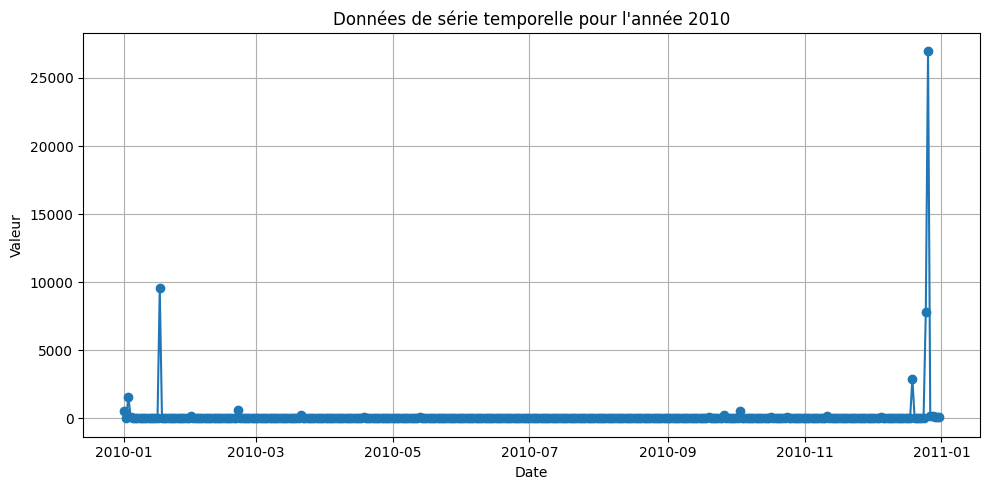

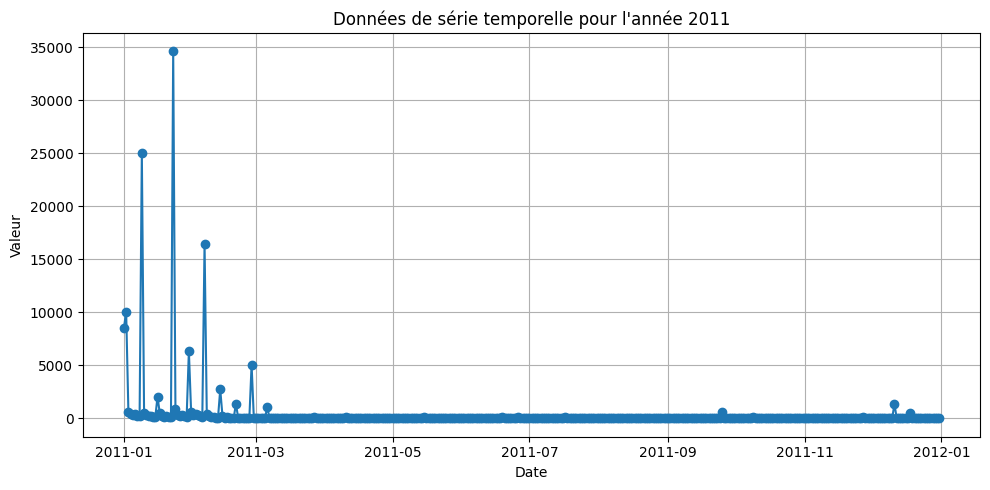

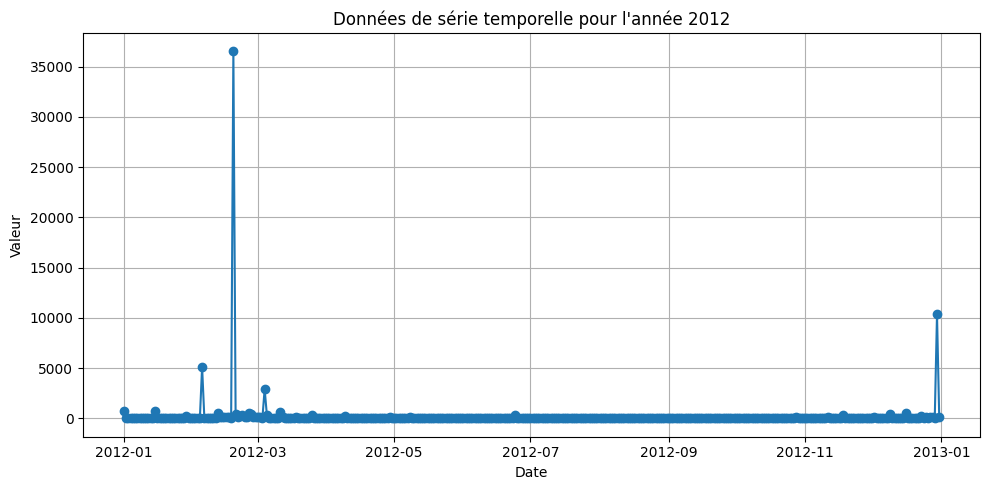

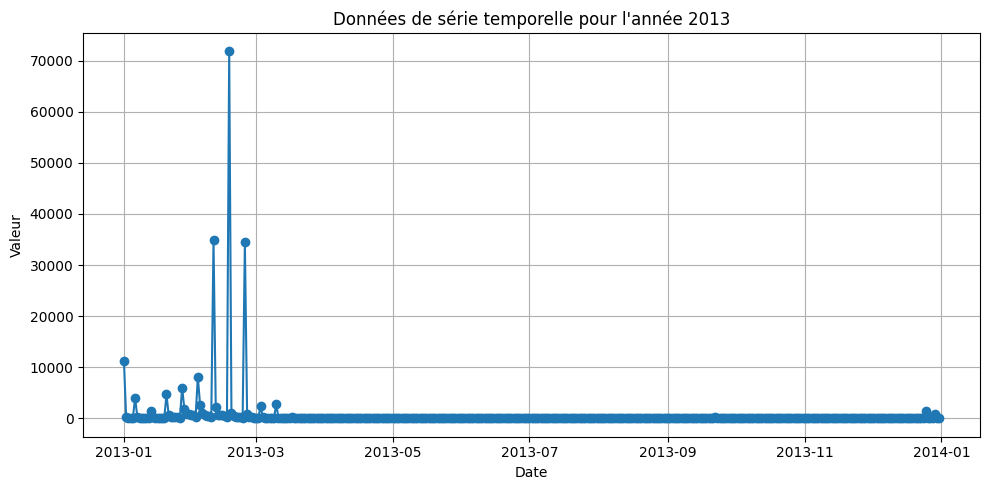

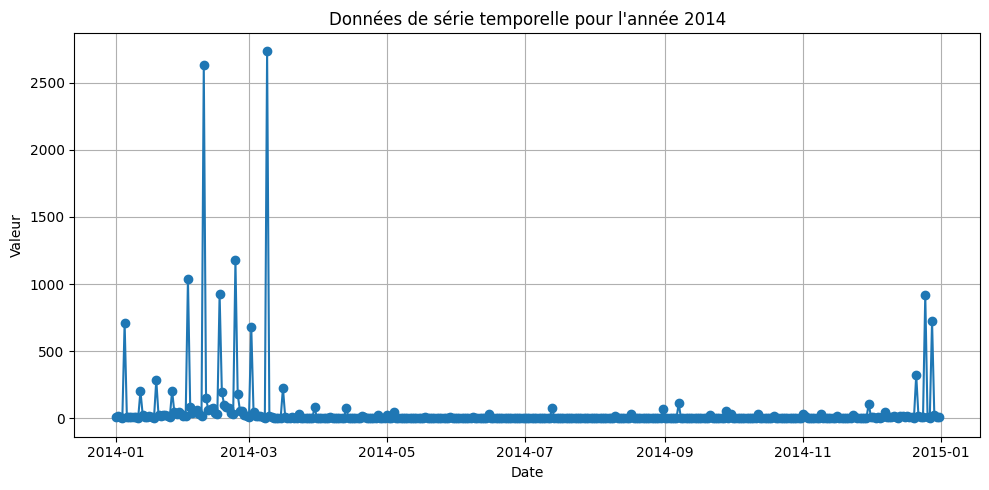

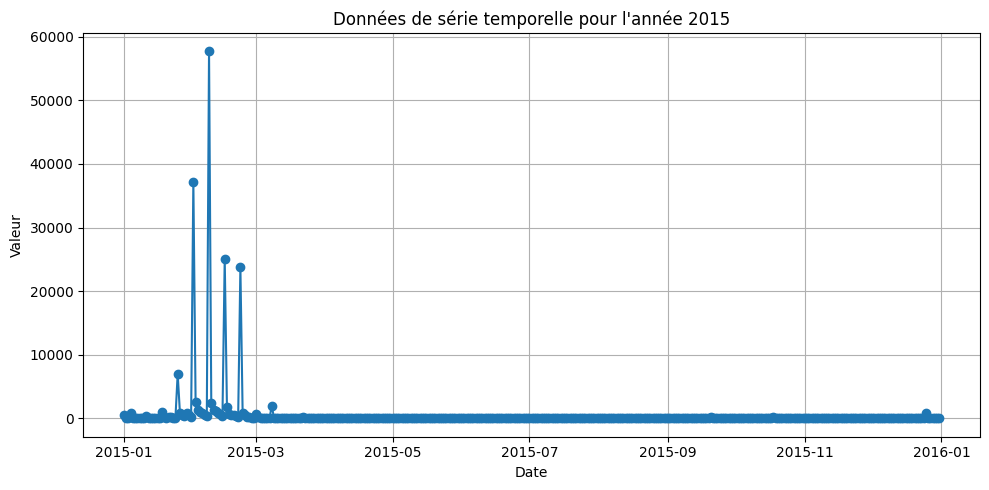

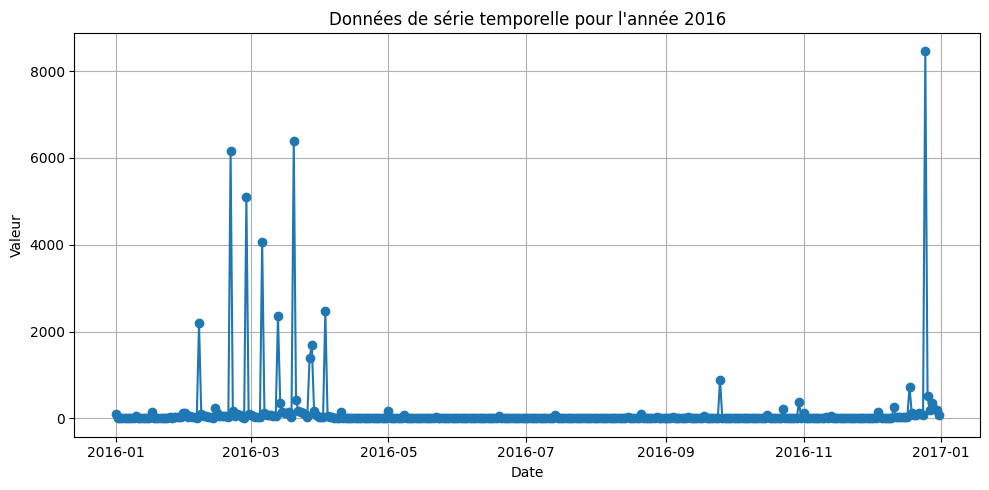

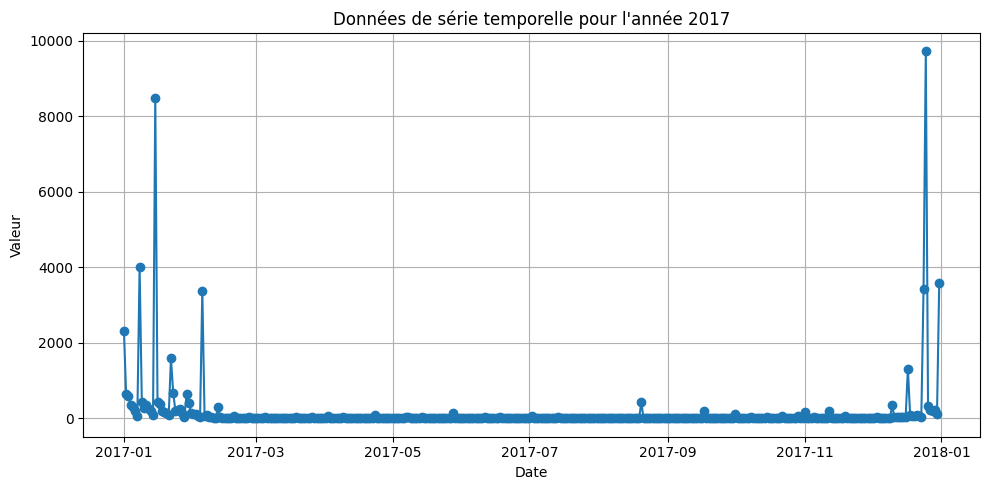

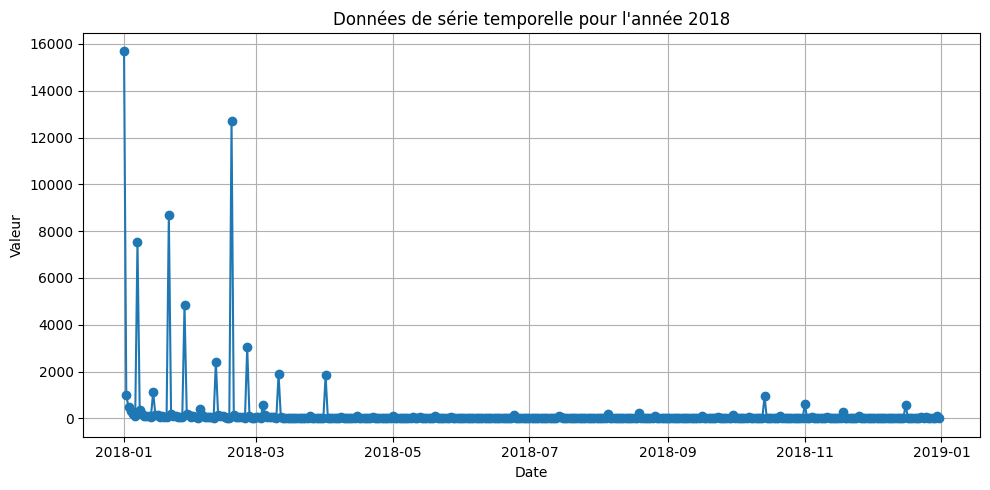

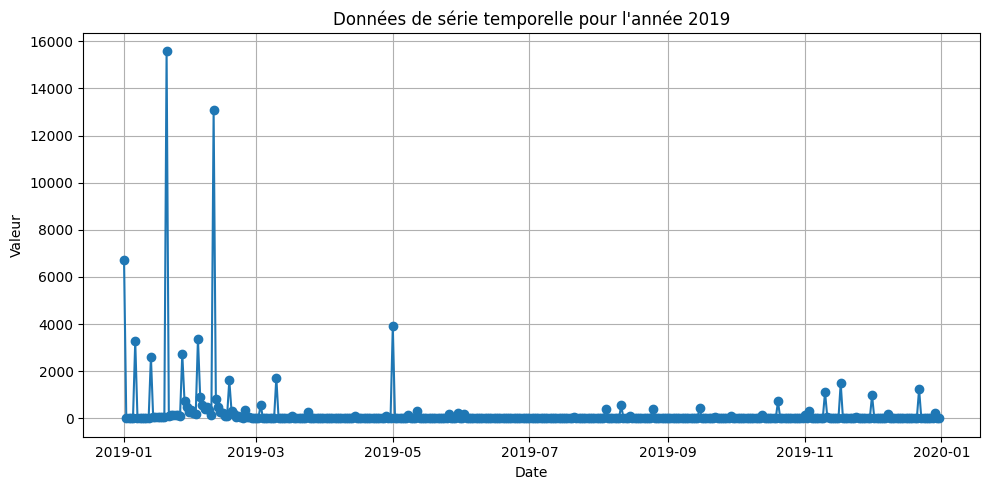

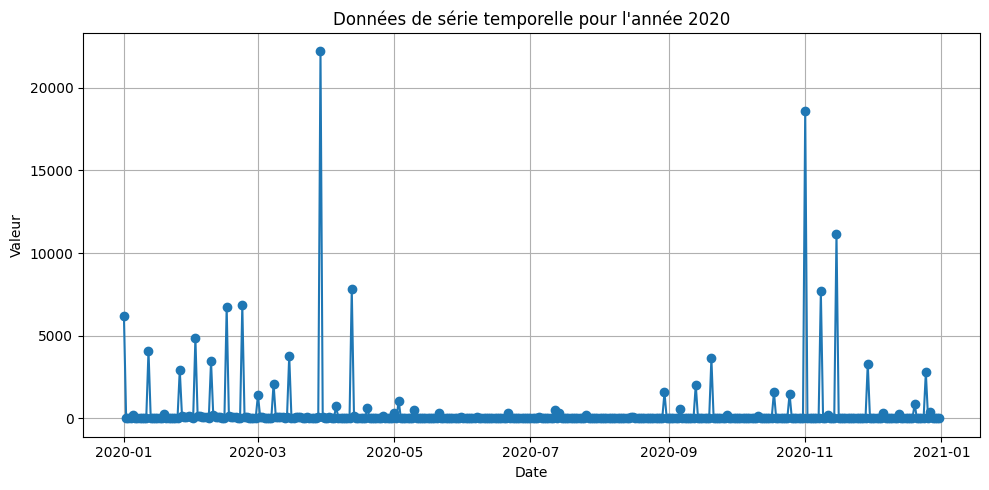

In [7]:
# Boucle sur les années uniques dans les données
for year in df.index.year.unique():
    if 2009 < year < 2021:
        # Sélectionner les données pour l'année donnée
        data_year = df[df.index.year == year]

        # Créer un graphique pour l'année donnée
        plt.figure(figsize=(10, 5))  # Ajuster la taille du graphique si nécessaire
        plt.plot(data_year.index, data_year['IAS_brut'], marker='o', linestyle='-')
        plt.title(f'Données de série temporelle pour l\'année {year}')
        plt.xlabel('Date')
        plt.ylabel('Valeur')
        plt.grid(True)
        plt.tight_layout()

        # Afficher le graphique
        plt.show()

On observe la présence d'une saisonalité marquée dans les données. La valeur de IAS_brut semble connaître un pic chaque année, lors des premiers de l'année. Nous observons cette même saisonnalité en fin d'année, mais elle est moins marquée et surtout, pas présente de façon aussi visible les années: 2011, 2013, 2015, 2018 et 2019. 

###  3) Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme a sur la trajectoire représentée à la question précédente?

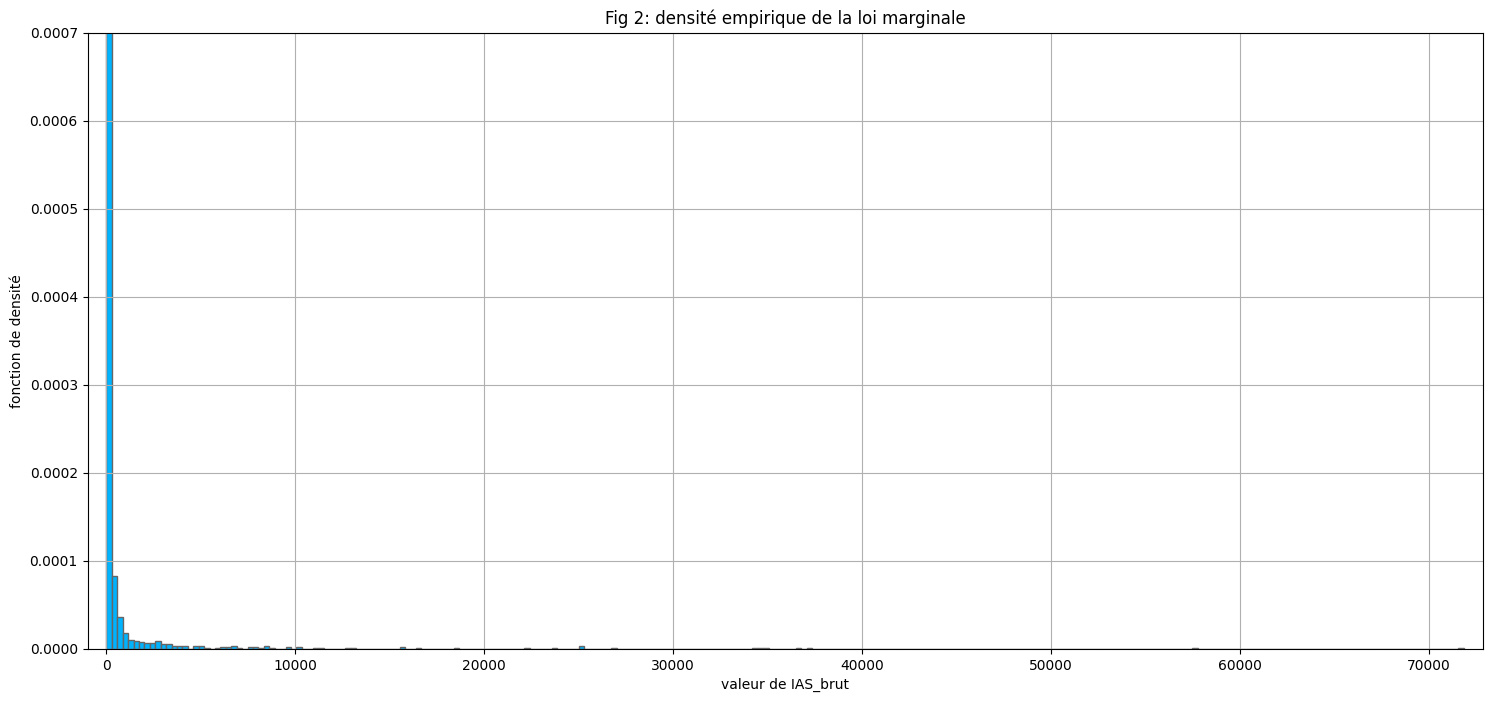

In [8]:
# traçage de l'histogramme de la loi marginale
fig2 = plt.figure(figsize=(18,8))
plt.hist(df['IAS_brut'], bins = 250, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('valeur de IAS_brut')
plt.ylabel('fonction de densité')
plt.title('Fig 2: densité empirique de la loi marginale')
plt.ylim(0, 0.0007) 
plt.xlim(df.IAS_brut.min()-1000,df.IAS_brut.max()+1000)
plt.grid(True)
plt.show()

On observe une distribution avec une asymétrie positive extrêmement élevée. La distribution compte une immense majorité de petites valeurs (entre 0 et 1000), quelques valeurs entre 1000 et 10000, puis une nombre très faible de valeurs extrêmes supérieures à 10000. Cette distribution implique que la trajectoire de la question précédente est caractérisée par une immense majorité de valeurs faibles, avant de connaître parfois des épisodes de valeurs extrêmes de courte durée. Autrement dit, la trajectoire de la question précédente est caractérisée par la présence d'hétéroscédasticité.

### 4) Reprenez les questions précédentes après tranformations des observations par le logarithme naturel. Commentez.

In [9]:
df['log_IAS_brut'] = np.log(df.IAS_brut)
df.head(2)

,IAS_brut,IAS_lissé,Incidence_Sentinelles,log_IAS_brut
PERIODE,,,,
2009-07-01,1.7,2.2,2.3,0.530628
2009-07-02,3.4,2.1,2.3,1.223775


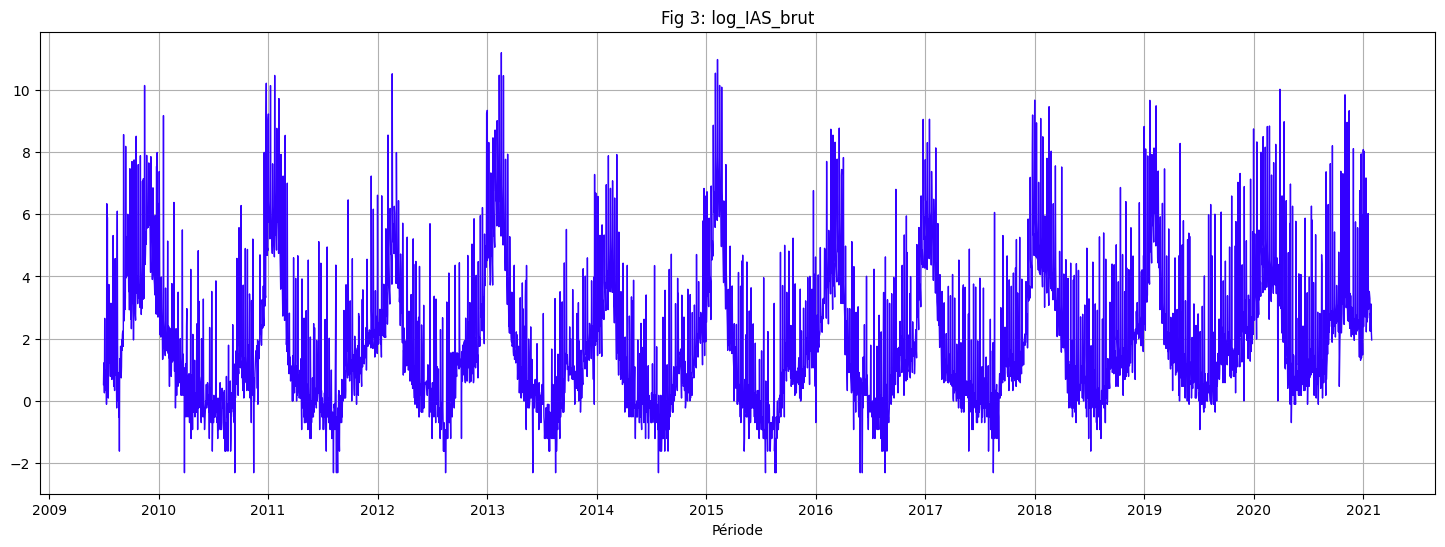

In [10]:
# Ajouter une colonne avec le logarithme de 'IAS_brut'
df['log_IAS_brut'] = np.log(df['IAS_brut'])

# Traçage du graphique de la série temporelle modifiée
plt.figure(figsize=(18,6))
plt.plot(df.index, df['log_IAS_brut'], linewidth=1, c=(0.2, 0, 1))
plt.title('Fig 3: log_IAS_brut')
plt.xlabel('Période')

# Formattage de l'axe des x avec les années
date_format = DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(YearLocator())

plt.grid(True)

# Afficher le graphique
plt.show()

On note que les données se sont considérablement ressérrées autour de la moyenne, la dispersion a été largement réduite par le passage en logarithme. La saisonalité reste toujours présente.

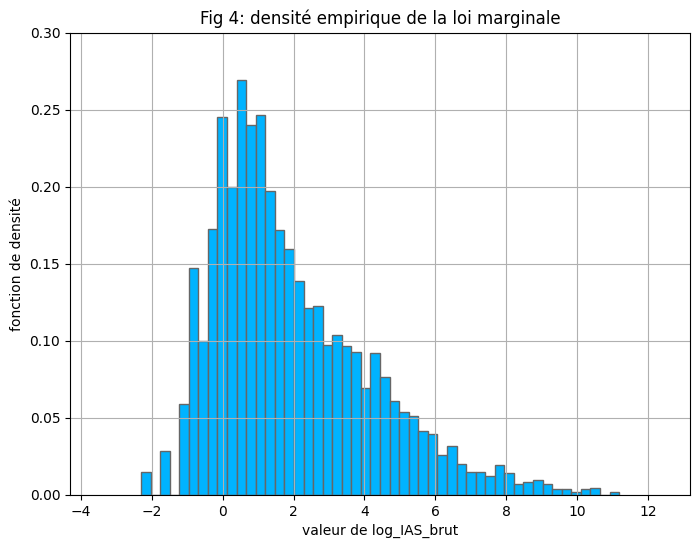

In [11]:
# traçage de l'histogramme de la loi marginale
fig4 = plt.figure(figsize=(8,6))
plt.hist(df['log_IAS_brut'], bins = 50, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('valeur de log_IAS_brut')
plt.ylabel('fonction de densité')
plt.title('Fig 4: densité empirique de la loi marginale')
plt.ylim(0, 0.30) 
plt.xlim(df.log_IAS_brut.min()-2,df.log_IAS_brut.max()+2)
plt.grid(True)
plt.show()

La distribution apparaît comme étant toujours positivement asymétrique, mais de façon moins extrême. Le passage en log a permis également de réduire la dispersion autour de la moyenne, la quasi-totalité des valeurs étant maintenant comprises entre -2 et 11.

### 5) En utilisant signal.periodogram() (du package signal importé depuis scipy), tracez le périodogramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans [−1/2, 1/2] plutôt que [−π, −π].

In [12]:
from scipy import signal

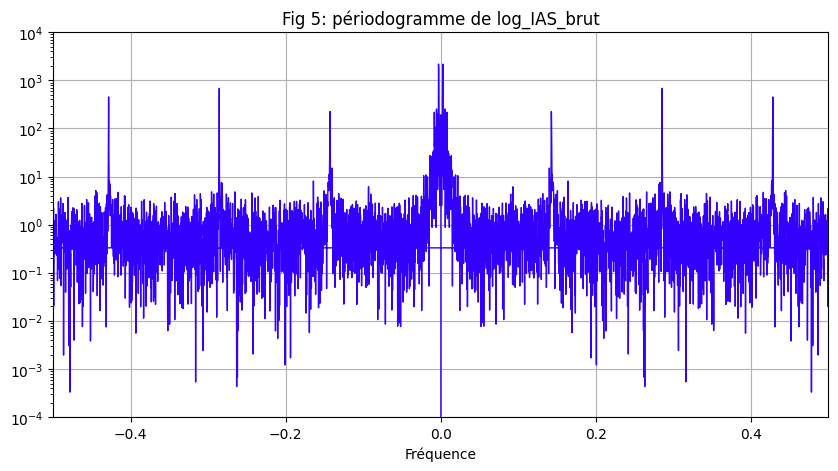

In [13]:
# estimation du périodogramme
f, Pxx = signal.periodogram(df['log_IAS_brut'], return_onesided = False)
# traçage du périodogramme
fig5 = plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, linewidth=1, c=(0.2, 0, 1))
plt.title('Fig 5: périodogramme de log_IAS_brut')
plt.xlabel('Fréquence')
plt.grid(True)
plt.xlim([-0.5, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

On observe un large pic autour des basses fréquences (entre 0 et 0.02, en valeur absolue), impliquant que ces dernières dominent le processus sous-jacent aux données. Cela explique un comportement exhibant des fluctuation cycliques lentes (à l'échelle de l'année), comme observé sur la Figure 4. On observe trois autres pics de fréquence, aux valeurs de 0.15, 0.30 et 0.45 (sur un spectre normalisé). Cela implique que les processus, en plus des basses fréquences, possède aussi quelques composantes significatives de moyennes et hautes fréquences, impliquant un certain nombre de cycles plus courts dans son comportement. Sur la Figure 3, on peut observer que ces cycles courts sont les plus significatifs en début d'année, ce qui indique une période de fluctuations rapides de la variable log_IAS_brut sur cette période.

### 6) Pour supprimer une tendance périodique de période T dans un signal (xt)t∈Z il suffit d’appliquer le filtre ∆T défini par
[∆T x]t = xt − xt−T

In [14]:
diff_log_IAS_brut = df['log_IAS_brut'].iloc[365:].to_numpy() - df['log_IAS_brut'].iloc[:-365].to_numpy()

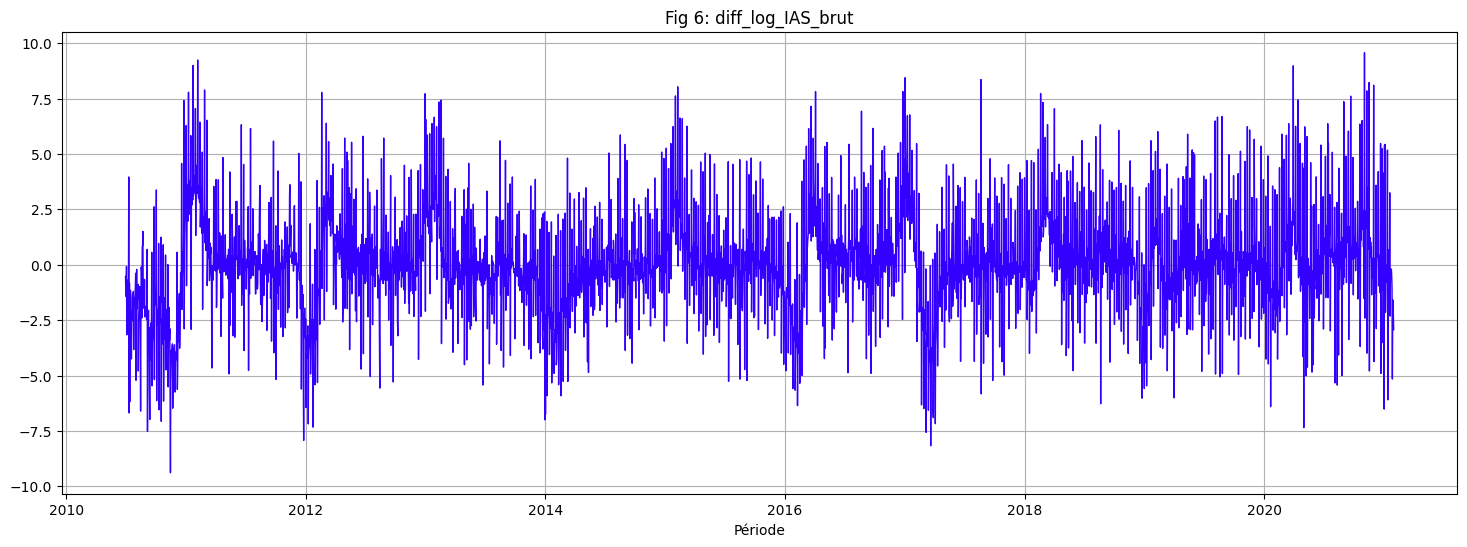

In [15]:
# traçage du graphique de la série temporelle modifiée
fig_6 = plt.figure(figsize=(18,6))
plt.plot(df.index[365:], diff_log_IAS_brut, linewidth=1, c=(0.2, 0, 1));
plt.title('Fig 6: diff_log_IAS_brut')
plt.xlabel('Période')
plt.grid(True)
plt.show()

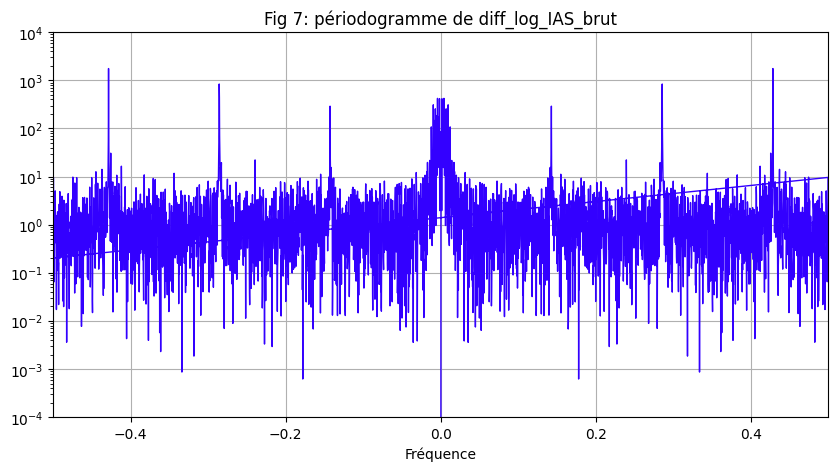

In [16]:
# estimation du périodogramme
f, Pxx = signal.periodogram(diff_log_IAS_brut, return_onesided = False)
# traçage du périodogramme
fig7 = plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, linewidth=1, c=(0.2, 0, 1))
plt.title('Fig 7: périodogramme de diff_log_IAS_brut')
plt.xlabel('Fréquence')
plt.grid(True)
plt.xlim([-0.5, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

En prenant la différence première avec les données une années auparavant, on s'attend à faire disparaître les cycles annuels. Dans notre set de données, ils correspondent à la plus basse fréquence, c'est-à-dire celle proche de zéro. On observe en effet quand dans notre périodogramme, le pic qui apparaissait exactement à 0 a disparu (comparer avec la Figure 5).

### 7) On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va
prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant
sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance
périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez
les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez
deux variables explicatives, xi,2k−1 = cos(ti · k · 2π ) et xi,2k = sin(ti · k · 2π ), où ti est le moment TT
de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicative

In [17]:
# définition des paramètres
n_harm = 5
T = 365

In [18]:
df_bis = df.reset_index(drop=False)
df_bis["t_i"] = df_bis.index+1

In [19]:
# on commence par rajouter une colonne de temps t_i sur le dataframe initial
data_time = df_bis.copy()
# on rajoute ensuite les séries de cosinus et sinus sur lesquels on regressera notre pseudo série de Fourier
for k in range(1, n_harm+1):
    data_time['cos_' + str(k)] = np.cos(data_time['t_i'] * k * (2*pi/T))
    data_time['sin_' + str(k)] = np.sin(data_time['t_i'] * k * (2*pi/T))

In [20]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PERIODE                4231 non-null   datetime64[ns]
 1   IAS_brut               4231 non-null   float64       
 2   IAS_lissé              4231 non-null   float64       
 3   Incidence_Sentinelles  3442 non-null   float64       
 4   log_IAS_brut           4231 non-null   float64       
 5   t_i                    4231 non-null   int64         
 6   cos_1                  4231 non-null   float64       
 7   sin_1                  4231 non-null   float64       
 8   cos_2                  4231 non-null   float64       
 9   sin_2                  4231 non-null   float64       
 10  cos_3                  4231 non-null   float64       
 11  sin_3                  4231 non-null   float64       
 12  cos_4                  4231 non-null   float64       
 13  sin

In [21]:
# on crée ensuite un dataframe d'apprentissage ne comprenant que les périodes et la variable d'intérêt
data_app = data_time[(data_time['PERIODE'] >= '2009-07-01') & (data_time['PERIODE'] <= '2013-03-31')]
data_app = data_app.drop(['IAS_lissé', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1)
# on crée enfin un dataframe de prédiction
data_pred = data_time[(data_time['PERIODE'] >= '2013-04-01') & (data_time['PERIODE'] <= '2014-04-17')]
data_pred = data_pred.drop(['IAS_lissé', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1)

In [22]:
data_app.tail()

,PERIODE,IAS_brut,cos_1,sin_1,cos_2,sin_2,cos_3,sin_3,cos_4,sin_4,cos_5,sin_5
1365,2013-03-27,7.6,-0.047321,-0.998880,-0.995521,0.094537,0.141540,0.989932,0.982126,-0.188227,-0.234491,-0.972118
1366,2013-03-28,7.1,-0.030120,-0.999546,-0.998186,0.060213,0.090252,0.995919,0.992749,-0.120208,-0.150055,-0.988678
1367,2013-03-29,4.9,-0.012910,-0.999917,-0.999667,0.025818,0.038722,0.999250,0.998667,-0.051620,-0.064508,-0.997917
1368,2013-03-30,4.3,0.004304,-0.999991,-0.999963,-0.008607,-0.012910,0.999917,0.999852,0.017213,0.021516,-0.999769
1369,2013-03-31,63.1,0.021516,-0.999769,-0.999074,-0.043022,-0.064508,0.997917,0.996298,0.085965,0.107381,-0.994218


In [23]:
# on passe les données en numpy pour pouvoir faire de la régression sous scikit learn
Y_app = data_app['IAS_brut'].to_numpy()
X_app = data_app.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
# estimation du modèle linéaire
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_app,Y_app);

In [24]:
# on crée maintenant les échantillons de prédiction
Y_pred = data_pred['IAS_brut'].to_numpy()
X_pred = data_pred.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
# on réalise la prédiction
pred = reg.predict(X_pred)
data_pred['pred'] = pred

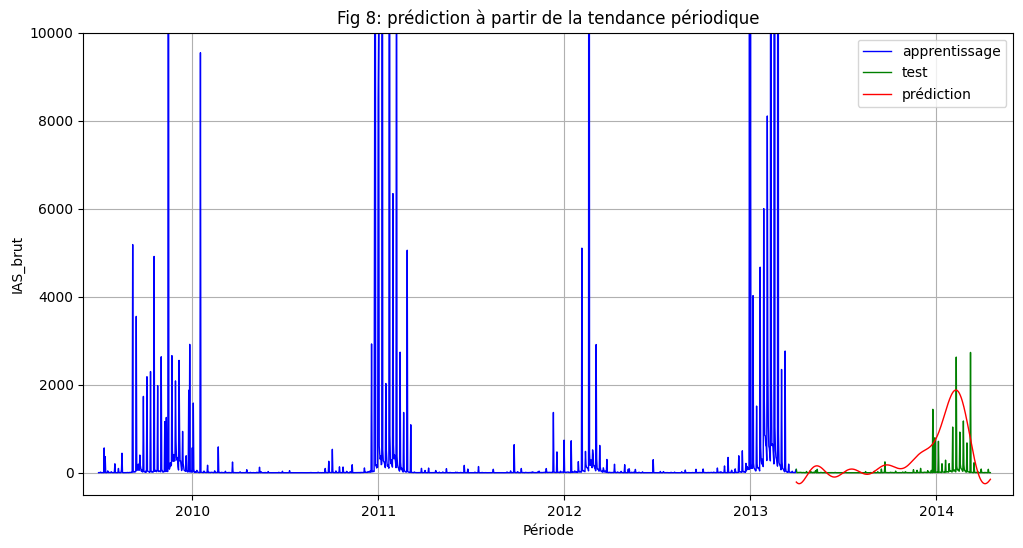

In [25]:
# on réalise le graphique
fig_8 = plt.figure(figsize=(12,6))
plt.plot(data_app['PERIODE'], data_app['IAS_brut'], linewidth=1, c="blue", label="apprentissage");
plt.plot(data_pred['PERIODE'], data_pred['IAS_brut'], linewidth=1, c="green", label="test");
plt.plot(data_pred['PERIODE'], data_pred['pred'], linewidth=1, c="red", label="prédiction");
plt.legend()
plt.title('Fig 8: prédiction à partir de la tendance périodique')
plt.xlabel('Période')
plt.ylabel('IAS_brut')
plt.xlim([datetime.date(2009, 6, 1), datetime.date(2014, 6, 1)])
plt.ylim([-500, 10000])
plt.grid(True)
plt.show()

In [26]:
# calcul du risque quadratique de la prédiction (normalisé par le nombre d'observations)
resids = Y_pred - pred
risk = np.sum(resids ** 2) / len(Y_pred)
print("le risque quadratique de la prédiction est de " + str(round(risk,2)) + ".")

le risque quadratique de la prédiction est de 384979.95.


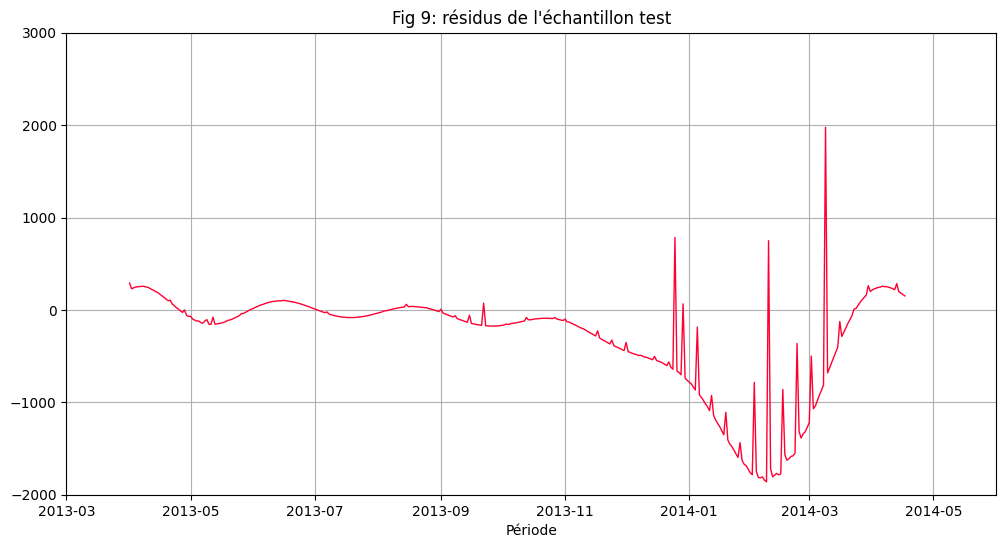

In [27]:
# traçage des résidus
fig_9 = plt.figure(figsize=(12,6))
plt.plot(data_pred['PERIODE'], resids, linewidth=1, c=(1, 0, 0.2));
plt.title("Fig 9: résidus de l'échantillon test")
plt.xlabel('Période')
plt.xlim([datetime.date(2013, 3, 1), datetime.date(2014, 6, 1)])
plt.ylim([-2000, 3000])
plt.grid(True)
plt.show()

In [28]:
# on essaye maintenant diverses valeurs de n_harm pour améliorer le risque quadratique de prédiction

# nombre maximum d'harmoniques à tester
max_n_harm = 100
    
# on boucle maintenant sur le nombre maximum d'harmoniques, estimant le modèle et le risque prédictif
risks = np.zeros([max_n_harm])
for n_harm in range(1, max_n_harm + 1):
    data_time = df_bis.copy()
    data_time['t_i'] = data_time.index + 1
    
    for k in range(1, n_harm + 1):
        data_time['cos_' + str(k)] = np.cos(data_time['t_i'] * k * (2*pi/T))
        data_time['sin_' + str(k)] = np.sin(data_time['t_i'] * k * (2*pi/T))
    
    # on crée ensuite un dataframe d'apprentissage ne comprenant que les périodes et la variable d'intérêt
    data_app = data_time[(data_time['PERIODE'] >= '2009-07-01') & (data_time['PERIODE'] <= '2013-03-31')]
    data_app = data_app.drop(['IAS_lissé', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1)
    # on crée enfin un dataframe de prédiction
    data_pred = data_time[(data_time['PERIODE'] >= '2013-04-01') & (data_time['PERIODE'] <= '2014-04-17')]
    data_pred = data_pred.drop(['IAS_lissé', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1)

    
    Y_app = data_app['IAS_brut'].to_numpy()
    X_app = data_app.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_app,Y_app);
    Y_pred = data_pred['IAS_brut'].to_numpy()
    X_pred = data_pred.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
    pred = reg.predict(X_pred)
    resids = Y_pred - pred
    risk = np.sum(resids ** 2) / len(Y_pred)
    risks[n_harm - 1] = risk

min_risk = min(risks)
min_harm = np.argmin(risks) + 1  

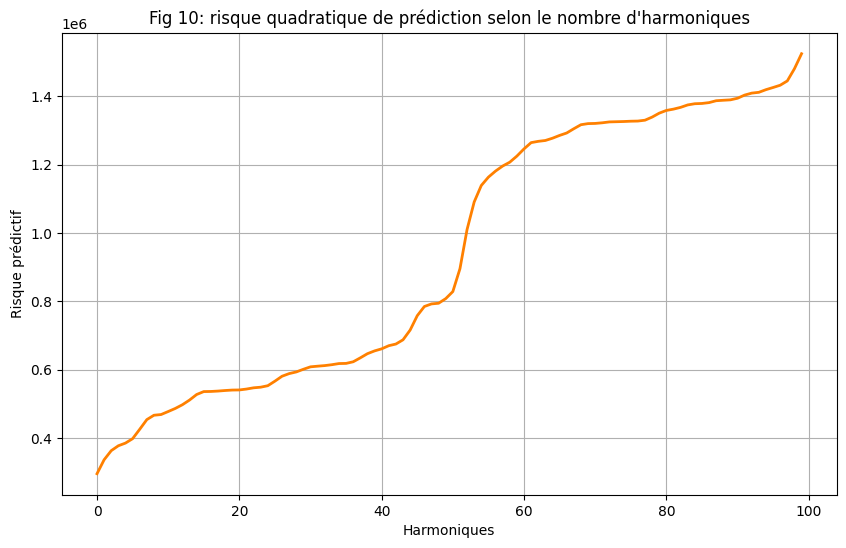

Le risque quadratique de prédiction minimum est de 295263. Il est atteint pour un modèle avec 1 harmoniques.


In [29]:
# traçage des valeurs de risque
fig_10 = plt.figure(figsize=(10,6))
plt.plot(risks, linewidth=2, c=(1, 0.5, 0));
plt.title("Fig 10: risque quadratique de prédiction selon le nombre d'harmoniques")
plt.xlabel('Harmoniques')
plt.ylabel('Risque prédictif')
plt.grid(True)
plt.show()

# impression du nombre d'harmoniques minimisant le risque
print("Le risque quadratique de prédiction minimum est de " + str(round(min_risk)) + ". Il est atteint pour un modèle avec " + str(min_harm) + " harmoniques.")

Commentaires:

Notre modèle de prédiction estime une pseudo suite de Fourier, prenant les 5 premières premières harmoniques (de basse, voire moyenne fréquence). Ces composantes sont aisément reconnaissables sur la Figure 8, avec d'une côté une sinusoide de cycle long visible sur la période allant de novembre 2013 à avril 2014, et des cycles un peu plus courts sur la période précédente.

Ce modèle fournit des résidus plutot satisfaisants sur la première période. Comme on peut le voir sur la Figure 9, ils sont alors centrés en 0, mais souffrent d'autocorrelation. Sur la seconde période en revanche, les performances du modèle sont médiocre. Le modèle essaie en effet de capturer les pics de haute fréquence de la série par ses composantes de basse fréquence. Lors des pics, la prédiction est ainsi plutôt bonne et les résidus sont centrés en 0. Hors des pics toutefois, la composante basse fréquence amène à systématiquement surestimer la prédiction, ce qui résulte en une série de larges résidus négatifs, comme on peut l'observer sur la Figure 9. Globalement, les performances sont peu satisfaisantes.

On peut alors essayer de jouer sur le paramètre n_harm pour améliorer les résutats. En testant un nombre d'harmoniques de 1 à 100, on observe que le meilleur résultat sur l'échantillon test est obtenu pour une seule harmonique. Cela implique que la meilleure représentation de la série est obtenue en prenant uniquement en compte la composante de plus basse fréquence, c'est-à-dire les cycles longs. En augmentant le nombre d'harmoniques pour essayer de capturer les fréquences plus élevées, on capture essentiellement du bruit. Cela illustre le compromis biais/variance: un modèle avec d'avantage d'harmoniques réduit le biais, mais l'augmentation de la variance amène finalement une détérioration de sa performance.